In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import pandas as pd

%load_ext autoreload
%autoreload 2

print(torch.__version__)
print(torchvision.__version__)

C:\Users\endo\anaconda3\envs\yolov7_custon\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.11.0+cu113
0.12.0+cu113


# Defining Path

In [3]:
import os
import sys
from pathlib import Path
sys.path.append('..')
sys.path.append('../examples')

# Data Loading

In [4]:
data_path = "../data/papilla/AnatomicalModel_Data"
data_path = Path(data_path)
images_path = data_path / "allimages" # all_images
annotations_file_path = data_path / "Papilla Detection-147.json" # annotations_final.csv

## Crop the Images

In [5]:
import cv2

images_list= os.listdir(images_path)## Creatng list of images from the actual image directory
print(f"Number of Images:{len(images_list)}")
# Verify coordinate values--> Change these values according to the image
####(tip- can use paint app to find the xmin,ymin,xmax,ymax)

xmin = 560  # example xmin value
ymin = 60  # example ymin value
xmax = 1680  # example xmax value
ymax = 1027  # example ymax value

images_list = os.listdir(images_path)
## Defining the directory for croped images
cropped_images_dir  = data_path / str("cropped_images-of-"+str(images_path).split("\\")[-1]) 

if not os.path.exists(cropped_images_dir):
    os.makedirs(cropped_images_dir)
    print(f"Created directory: {cropped_images_dir}")
    
    for image_name in images_list:
        # Load the image
        image_path = images_path / image_name
        
        image = cv2.imread(str(image_path))

        # Perform cropping
        cropped_image = image[ymin:ymax, xmin:xmax]
        # Save the cropped image
        cropped_image_path = cropped_images_dir / image_name
        cv2.imwrite(str(cropped_image_path), cropped_image)
#         print(f"Cropped image saved: {cropped_image_path}")
#         break  # Uncomment this line if you want to crop only the first image for testing purposes

else:
    print(f"Directory already exists: {cropped_images_dir}")


Number of Images:1621
Directory already exists: ..\data\papilla\AnatomicalModel_Data\cropped_images-of-allimages


## Reading the Json file, Updating Bounding Box, Creating Dataframe

In [6]:
# I have the filename: Extracting other information from data['annotations']
#But file name is present in data['images']
# We need to search for the ID in data['images'] wrt to the filename
# Then map each id with its respective image_id in data['annotations']--> from here we can extarct the information 
#LIke bbox, category_id 
# Reading the Annotation File

import json
import numpy as np

with open(annotations_file_path, 'r') as f:
        data = json.load(f)
        
papilla_images_list = os.listdir(images_path)

## Creating dataframe    
my_df= {'image':[], 'xmin':[],'ymin':[], 'xmax':[], 'ymax':[], 'class_name':[], 'has_annotation':[], 'image_id':[], 'class_id':[]}
for filename in papilla_images_list:
    
    my_id= [d for d in data['images'] if d['file_name']== filename][0]['id']
    my_data= [d for d in data['annotations'] if d['image_id']== my_id] 
    filtered_data = [d for d in my_data if d['category_id'] != 216][0]    
#     print(filtered_data)
    my_df['image'].append(filename)
    my_df['image_id'].append(np.nan)
    
    if filtered_data['category_id']==168:
        
        my_df['class_name'].append('background')
        my_df['class_id'].append(np.nan)
        my_df['has_annotation'].append(False)## Im assuming if its a background (category id 168) there is no annotation

        my_df['xmin'].append(np.nan)
        my_df['ymin'].append(np.nan)
        my_df['xmax'].append(np.nan)
        my_df['ymax'].append(np.nan)
        
        
    else:
        
        original_bbox= filtered_data['bbox']# The bbox is in the format [xmin, ymin, w, h]
        
        crop_width = xmax - xmin
        crop_height = ymax - ymin
        
        # Converting bbox according to the cropped image and converting the format to [xmin, ymin, xmax, ymax]
        new_xmin = max(0, original_bbox[0] - xmin)
        new_ymin = max(0, original_bbox[1] - ymin)
        new_xmax = min(crop_width, original_bbox[0] + original_bbox[2] - xmin)
        new_ymax = min(crop_height, original_bbox[1] + original_bbox[3] - ymin)

#         print(bbox)
        my_df['class_name'].append('papilla')
        my_df['class_id'].append(0.0)
        my_df['has_annotation'].append(True)
    
        my_df['xmin'].append(new_xmin)
        my_df['ymin'].append(new_ymin)
        my_df['xmax'].append(new_xmax)# The bounding boxes are in the format x,y,w,g, from coco annotater
        my_df['ymax'].append(new_ymax)# Hence converting w & h to xmax, ymax 
        
final_df=  pd.DataFrame.from_dict(my_df)
final_df.image_id= list(range(1, len(final_df)+1))
final_df

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
0,000001-001-00217.png,NaN,NaN,NaN,NaN,background,False,1,NaN
1,000001-001-00229.png,NaN,NaN,NaN,NaN,background,False,2,NaN
2,000001-001-00241.png,NaN,NaN,NaN,NaN,background,False,3,NaN
3,000001-001-00253.png,NaN,NaN,NaN,NaN,background,False,4,NaN
4,000001-001-00265.png,NaN,NaN,NaN,NaN,background,False,5,NaN
...,...,...,...,...,...,...,...,...,...
1616,00000300081.png,NaN,NaN,NaN,NaN,background,False,1617,NaN
1617,00000300101.png,NaN,NaN,NaN,NaN,background,False,1618,NaN
1618,00000300121.png,NaN,NaN,NaN,NaN,background,False,1619,NaN
1619,00000300141.png,NaN,NaN,NaN,NaN,background,False,1620,NaN


In [7]:
final_df.nunique()

image             1621
xmin               379
ymin               278
xmax               247
ymax               355
class_name           2
has_annotation       2
image_id          1621
class_id             1
dtype: int64

## Now continuing using the cropped image path and the annotation (dataframe)

In [8]:
import pandas as pd
import random

def load_cars_df(df):
    display(df)
    # all_images = sorted(set([p.parts[-1] for p in images_path.iterdir()]))
    image_id_to_image = {i: im for i, im in zip(df.image_id, df.image)}
    image_to_image_id = {v: k for k, v, in image_id_to_image.items()}
    
    class_id_to_label = dict(
        enumerate(df.query("has_annotation == True").class_name.unique())
    )
    class_label_to_id = {v: k for k, v in class_id_to_label.items()}
        
    from sklearn.model_selection import train_test_split
    # first, split into X_train, X_valid_test, y_train, y_valid_test
    # `test_size=0.3` split into 70% and 30%
    train_df, valid_test_df = train_test_split(df, test_size=0.3, random_state=42)

    # second, split into X_valid, X_test, y_valid, y_test
    # `test_size=0.5` split into 50% and 50%. The original data set is 30%,
    # so, it will split into 15% equally.
    valid_df, test_df = train_test_split(valid_test_df, test_size=0.5, random_state=42)

    lookups = {
        "image_id_to_image": image_id_to_image,
        "image_to_image_id": image_to_image_id,
        "class_id_to_label": class_id_to_label,
        "class_label_to_id": class_label_to_id,
    }
    return train_df, valid_df, test_df, lookups

We can now use this function to load our data:

In [9]:
train_df, valid_df, test_df, lookups = load_cars_df(final_df)

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
0,000001-001-00217.png,NaN,NaN,NaN,NaN,background,False,1,NaN
1,000001-001-00229.png,NaN,NaN,NaN,NaN,background,False,2,NaN
2,000001-001-00241.png,NaN,NaN,NaN,NaN,background,False,3,NaN
3,000001-001-00253.png,NaN,NaN,NaN,NaN,background,False,4,NaN
4,000001-001-00265.png,NaN,NaN,NaN,NaN,background,False,5,NaN
...,...,...,...,...,...,...,...,...,...
1616,00000300081.png,NaN,NaN,NaN,NaN,background,False,1617,NaN
1617,00000300101.png,NaN,NaN,NaN,NaN,background,False,1618,NaN
1618,00000300121.png,NaN,NaN,NaN,NaN,background,False,1619,NaN
1619,00000300141.png,NaN,NaN,NaN,NaN,background,False,1620,NaN


In [10]:
train_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
1200,000003-001-01513.png,NaN,NaN,NaN,NaN,background,False,1201,NaN
155,000001-001-03589.png,595.0,32.0,933.0,372.0,papilla,True,156,0.0
1422,000003-001-2-00169.png,NaN,NaN,NaN,NaN,background,False,1423,NaN
1226,000003-001-02425.png,538.0,188.0,1045.0,726.0,papilla,True,1227,0.0
490,000002-001-01321.png,518.0,106.0,932.0,537.0,papilla,True,491,0.0


In [11]:
valid_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
203,000001-001-05569.png,635.0,186.0,1046.0,597.0,papilla,True,204,0.0
411,00000100461.png,NaN,NaN,NaN,NaN,background,False,412,NaN
1197,000003-001-01477.png,NaN,NaN,NaN,NaN,background,False,1198,NaN
694,000002-001R-01009.png,374.0,161.0,839.0,640.0,papilla,True,695,0.0
997,000002-002-05989.png,782.0,312.0,1120.0,806.0,papilla,True,998,0.0


In [12]:
test_df.head()

,image,xmin,ymin,xmax,ymax,class_name,has_annotation,image_id,class_id
774,000002-001R-04345.png,352.0,296.0,936.0,912.0,papilla,True,775,0.0
199,000001-001-05521.png,651.0,186.0,1031.0,597.0,papilla,True,200,0.0
1234,000003-001-02521.png,541.0,172.0,1042.0,693.0,papilla,True,1235,0.0
596,000002-001-06589.png,460.0,341.0,873.0,775.0,papilla,True,597,0.0
745,000002-001R-01621.png,396.0,85.0,849.0,543.0,papilla,True,746,0.0


In [13]:
print(train_df.image.nunique(), valid_df.image.nunique(), test_df.image.nunique())

1134 243 244


To make it easier to associate predictions with an image, we have assigned each image a unique id; in this case it is just an incrementing integer count. Additionally, we have added an integer value to represent the classes that we want to detect, which is a single class - 'car' - in this case.

Generally, object detection models reserve `0` as the background class, so class labels should start from `1`. This is **not** the case for Yolov7, so we start our class encoding from `0`. For images that do not contain a car, we do not require a class id. We can confirm that this is the case by inspecting the lookups returned by our function.

In [14]:
lookups.keys()

dict_keys(['image_id_to_image', 'image_to_image_id', 'class_id_to_label', 'class_label_to_id'])

In [15]:
lookups['class_label_to_id'], lookups['class_id_to_label']

({'papilla': 0}, {0: 'papilla'})

Finally, let's see the number of images in each class for our training and validation sets. As an image can have multiple annotations, we need to make sure that we account for this when calculating our counts:

In [16]:
print(f"Num. annotated images in training set: {len(train_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in training set: {len(train_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in training set: {len(train_df.image.unique())}")
print('------------')

print(f"Num. annotated images in validation set: {len(valid_df.query('has_annotation == True').image.unique())}")
print(f"Num. Background images in validation set: {len(valid_df.query('has_annotation == False').image.unique())}")
print(f"Total Num. images in validation set: {len(valid_df.image.unique())}")

Num. annotated images in training set: 540
Num. Background images in training set: 594
Total Num. images in training set: 1134
------------
Num. annotated images in validation set: 119
Num. Background images in validation set: 124
Total Num. images in validation set: 243


## Create a Dataset Adaptor

In [17]:
from train_cars import CarsDatasetAdaptor

INFO:pytorch_accelerated:Setting random seeds


In [18]:
train_ds = CarsDatasetAdaptor(cropped_images_dir, train_df)
valid_ds= CarsDatasetAdaptor(cropped_images_dir, valid_df)
test_ds= CarsDatasetAdaptor(cropped_images_dir, test_df)

In [19]:
train_ds

### Transforms

In [20]:
from yolov7.dataset import Yolov7Dataset
from yolov7.dataset import create_yolov7_transforms
from yolov7.plotting import show_image

In [21]:
target_image_size = 640

In [22]:
train_yds = Yolov7Dataset(train_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))
eval_yds= Yolov7Dataset(valid_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))
test_yds= Yolov7Dataset(test_ds, transforms=create_yolov7_transforms(image_size=(target_image_size, target_image_size)))

## Visualization

Image: torch.Size([3, 640, 640])
Labels: tensor([[0.0000, 0.0000, 0.6424, 0.5671, 0.3955, 0.4495]])


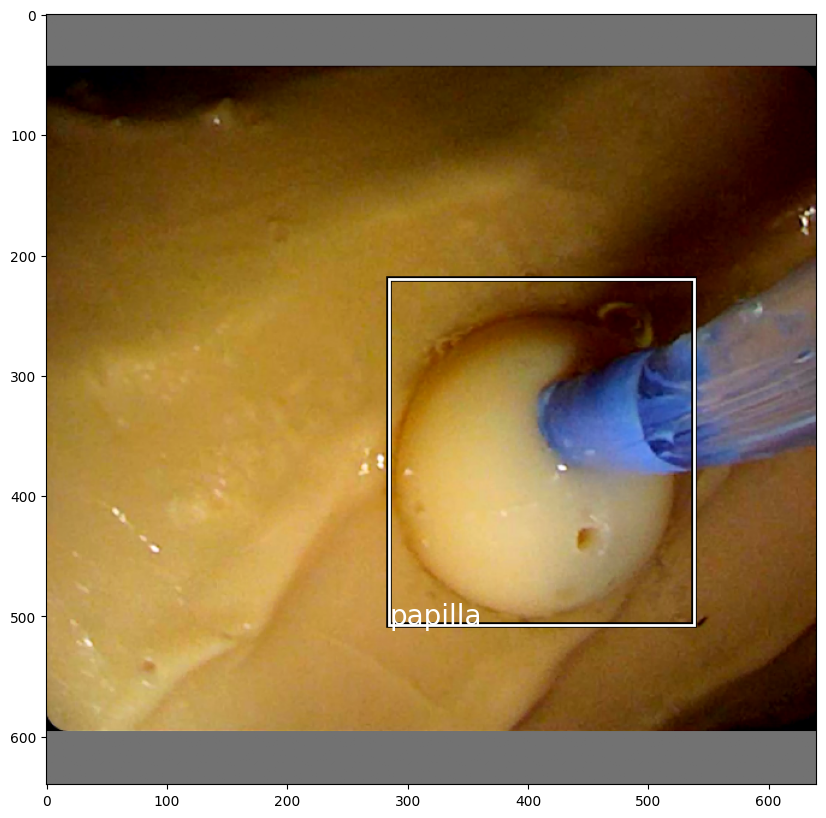

Image id: 590
Image size: tensor([ 967, 1120])


In [23]:
idx = 16
    
image_tensor, labels, image_id, image_size = train_yds[idx]

print(f'Image: {image_tensor.shape}')
print(f'Labels: {labels}')

# denormalize boxes
boxes = labels[:, 2:]
boxes[:, [0, 2]] *= target_image_size #image_size[1]## Multiplying with targetimagesize becasue, padding was applied (using transforms above)
boxes[:, [1, 3]] *= target_image_size #image_size[0]

show_image(image_tensor.permute( 1, 2, 0), boxes.tolist(), [lookups['class_id_to_label'][int(c)] for c in labels[:, 1]], 'cxcywh')
plt.show()
print(f'Image id: {image_id}')
print(f'Image size: {image_size}')

### Training from Scratch

In [26]:
from yolov7.trainer import Yolov7Trainer

In [27]:
# CHangint the path: this is the path wehre the trained weight (.pt) file is created
%cd "C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\examples\"

C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\examples


In [28]:
import random
from functools import partial
from pathlib import Path

import numpy as np
import pandas as pd
import torch
from func_to_script import script
from PIL import Image
from pytorch_accelerated.callbacks import (
    ModelEmaCallback,
    ProgressBarCallback,
    SaveBestModelCallback,
    get_default_callbacks,
    EarlyStoppingCallback
)
from pytorch_accelerated.schedulers import CosineLrScheduler
from torch.utils.data import Dataset

from yolov7 import create_yolov7_model
from yolov7.dataset import (
    Yolov7Dataset,
    create_base_transforms,
    create_yolov7_transforms,
    yolov7_collate_fn,
)
from yolov7.evaluation import CalculateMeanAveragePrecisionCallback
from yolov7.loss_factory import create_yolov7_loss
from yolov7.mosaic import MosaicMixupDataset, create_post_mosaic_transform
from yolov7.trainer import Yolov7Trainer, filter_eval_predictions
from yolov7.utils import SaveBatchesCallback, Yolov7ModelEma

# Training code

In [ ]:
# Finetuning the model

DATA_PATH =data_path

def finetune_training(
    train_ds, valid_ds,
    data_path: str = DATA_PATH,
    image_size: int = 640,
    pretrained: bool = True,
    num_epochs: int = 50,
    batch_size: int = 8,
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu',# Add this line to set the device to use
):
    
    
##############################################################################
    # CHecking on which device the training is going to run
    print(device)
    #Code added by Mike: print name of GPU
    print(torch.cuda.get_device_name(torch.cuda.current_device()))
    
##############################################################################
    
##############################################################################

    num_classes= 1
    
##############################################################################

    train_yds = Yolov7Dataset(
        train_ds,
        create_yolov7_transforms(training=True, image_size=(image_size, image_size)),
    )
    eval_yds = Yolov7Dataset(
        valid_ds,
        create_yolov7_transforms(training=False, image_size=(image_size, image_size)),
    )
##############################################################################

    # Create model, loss function and optimizer
    model = create_yolov7_model(
        architecture="yolov7", num_classes=num_classes, pretrained=pretrained
    ).to(device) # Dheeraj added .to(torch.device("cpu")) 
    
##############################################################################

    loss_func = create_yolov7_loss(model, image_size=image_size)
    
##############################################################################

    optimizer = torch.optim.SGD(
        model.parameters(), lr=0.01, momentum=0.9, nesterov=True
    )
    
##############################################################################

    # create evaluation callback and trainer
    calculate_map_callback = (
        CalculateMeanAveragePrecisionCallback.create_from_targets_df(
            targets_df=valid_df.query("has_annotation == True")[
                ["image_id", "xmin", "ymin", "xmax", "ymax", "class_id"]
            ],
            image_ids=set(valid_df.image_id.unique()),
            iou_threshold=0.2,
        )
    )
    
##############################################################################
    # Create trainer and train
    trainer = Yolov7Trainer(
        model=model,
        optimizer=optimizer,
        loss_func=loss_func,
        filter_eval_predictions_fn=partial(
            filter_eval_predictions, confidence_threshold=0.01, nms_threshold=0.3
        ),
        callbacks=[
            calculate_map_callback,
            SaveBestModelCallback(watch_metric="map", greater_is_better=True),
            EarlyStoppingCallback(
                early_stopping_patience=3,
                watch_metric="map",
                greater_is_better=True,
                early_stopping_threshold=0.001,
            ),
            *get_default_callbacks(progress_bar=True),
        ],
    )
    
##############################################################################


    trainer.train(
        num_epochs=num_epochs,
        train_dataset=train_yds,
        eval_dataset=eval_yds,
        per_device_batch_size=batch_size,
        create_scheduler_fn=CosineLrScheduler.create_scheduler_fn(
            num_warmup_epochs=5,
            num_cooldown_epochs=5,
            k_decay=2,
        ),
        collate_fn=yolov7_collate_fn,
    )

##############################################################################

In [ ]:
finetune_training(train_ds, valid_ds)

The notable differences between the "Training from Scratch" and "Fine-tuning" scenarios in the provided script:

Fine-tuning the model:

Dataset: The script defines train_yds and eval_yds using the Yolov7Dataset and create_yolov7_transforms functions for both training and evaluation datasets.

Optimizer: The optimizer is created using model.parameters() instead of model.get_parameter_groups().
Early Stopping: The script includes the EarlyStoppingCallback in the list of trainer callbacks, which helps stop training early if the metric does not improve.

No Gradient Accumulation Steps: Unlike the "Training from Scratch" script, there is no calculation or mention of gradient accumulation steps in the "Fine-tuning" script.

### Calculating mAP, Precision and Recall on Test set

##### I have created my own code for calculation of mAP, Precison, Recall, and Precision-Recall Curve
##### But this might not be necessary if we can use the functions provided in the evaluation folder correctly
##### Path for evaluation folder: C:\Users\endo\Desktop\Yolov7-training-main\Yolov7-training-main\yolov7\evaluation
##### Some idea on how to use it can be learnt from the above cell (Training Code), where the callbacks for calcualtion mAP were used

In [ ]:
# Defining model 
best_model = create_yolov7_model('yolov7', num_classes=1)
best_model.eval();

In [ ]:
# Loading Weights
# Remember to change the .pt file as per the trained weights you have or want to test with
best_model_path= 'C:\\Users\\endo\\Desktop\\Yolov7-training-main\\Yolov7-training-main\\examples\\model_weights_julie_anatomical_model_data.pt'
checkpoint = torch.load(best_model_path)
state_dict = checkpoint['model_state_dict']
best_model.load_state_dict(state_dict)

## Running inference on test_yds

In [ ]:
import torch
for idx in range(len(test_yds)):
    image_tensor, labels, image_id, image_size = test_yds[idx]
    with torch.no_grad():
        model_outputs = best_model(image_tensor[None])
        preds = best_model.postprocess(model_outputs, conf_thres=0., multiple_labels_per_box=False)

        # Inference
        nms_predictions = filter_eval_predictions(preds, confidence_threshold=0.1)
        nms_predictions[0].shape
        pred_boxes = nms_predictions[0][:, :4]
        class_ids = nms_predictions[0][:, -1]

        show_image(image_tensor.permute( 1, 2, 0), pred_boxes.tolist(), class_ids.tolist())
        plt.show()
        print(preds)
#         print(f'Image id: {image_id}')
#         print(f'Original Image size: {image_size}')
#         print(f'Resized Image size: {image_tensor.shape[1:]}')
    break

In [ ]:
def intersection_over_union(boxes_preds, boxes_labels, box_format= "corners"):
    # (N,4): N--number of bboxes
    # boxes_labels shape is (N,4)
    
    '''Calculates intersection over union
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct Labels of Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)
    Returns:
        tensor: Intersection over union for all examples
        '''       
    if box_format == "corners":
        
        #Converting cx,cy,w,h (center_x, center_y,w,h) into (xmin, ymin, xmax, ymax)
        
#         print(boxes_labels)
#         print(boxes_preds)
        
        center_x= boxes_labels[..., 0:1]
        center_y = boxes_labels[..., 1:2] 
        width = boxes_labels[..., 2:3] 
        height= boxes_labels[..., 3:4] 
        new_boxes_labels = torch.zeros_like(boxes_labels) # Initializing the tensor

        new_boxes_labels[..., 0:1]= center_x - (width / 2)
        new_boxes_labels[..., 1:2]= center_y - (height / 2)
        new_boxes_labels[..., 2:3]= center_x + (width / 2)
        new_boxes_labels[..., 3:4]= center_y + (height / 2)        
        
        
        pred_xmin= boxes_preds[..., 0:1]
        pred_ymin= boxes_preds[..., 1:2]
        pred_xmax= boxes_preds[..., 2:3]
        pred_ymax= boxes_preds[..., 3:4]

        label_xmin= new_boxes_labels[..., 0:1]
        label_ymin= new_boxes_labels[..., 1:2]
        label_xmax= new_boxes_labels[..., 2:3]
        label_ymax= new_boxes_labels[..., 3:4]

    inter_area = max(0, min(pred_xmax, label_xmax) - max(pred_xmin, label_xmin)) * \
             max(0, min(pred_ymax, label_ymax) - max(pred_ymin, label_ymin))

    pred_area = (pred_xmax - pred_xmin) * (pred_ymax - pred_ymin)
    label_area = (label_xmax - label_xmin) * (label_ymax - label_ymin)
    union_area = pred_area + label_area - inter_area

    iou = inter_area / union_area
    conf= boxes_preds[...,4:5]
    return iou, conf
        

In [ ]:
# Validation Image
df_list=[]
iou_thres= 0.5
for i in range(len(test_df)):
    
    # Taking a test image
    image_tensor, labels, image_id, image_size = test_yds[i]
    boxes_labels = labels[:, 2:]
    boxes_labels[:, [0, 2]] *= target_image_size
    boxes_labels[:, [1, 3]] *= target_image_size
    
    # Predicting 
    with torch.no_grad():
        model_outputs = best_model(image_tensor[None])
        preds = best_model.postprocess(model_outputs, conf_thres=0., multiple_labels_per_box=False)  
        
    # This has the bounding boxes with confidence and class label
    nms_predictions = filter_eval_predictions(preds, confidence_threshold=0.1)
    data= {'image_id':[],'gt_flag':[],'pd_flag':[], 'confidence':[], 'iou':[], 'tp':[], 'fp':[], 'fn':[], 'tn':[]}
    
    
    # Chec if the Ground Truth Bbox is available:
    if boxes_labels.numel()==0:
        # Now check if Predicted Bounding boxes are zero or any got predicted:
        if nms_predictions[0].numel()==0:
#             print(" We dont care about this case")
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(1)
            data['pd_flag'].append(1)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(np.nan)
            data['fp'].append(np.nan)
            data['tn'].append(1)
        elif nms_predictions[0].numel()!=0:
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(1)
            data['pd_flag'].append(0)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(np.nan)
            data['fp'].append(1)
            data['tn'].append(np.nan)
    # this is when the ground truth bounding box is available:
    else:
        # Now we chck if the prediction are done or not:
        # Checking if there are no predictions:
        if nms_predictions[0].numel()==0:
            data['image_id']= image_id.tolist()
            data['gt_flag'].append(0)
            data['pd_flag'].append(1)
            data['confidence'].append(np.nan)
            data['iou'].append(np.nan)
            data['tp'].append(np.nan)
            data['fn'].append(1)
            data['fp'].append(np.nan)
            data['tn'].append(np.nan)
        # Checking ig the prediction is done
        elif nms_predictions[0].numel()!=0:
            # In this case we check for IOU:
            # First we check of the number of predictions are 1 or more:
#             my_iou_list=[]
#             confidence= []
            
            if len(nms_predictions[0])>1:
                for j in range(len(nms_predictions[0])):
                    my_iou, conf= intersection_over_union(nms_predictions[0][j], boxes_labels, box_format= "corners")
#                     print(conf)
                    if my_iou> iou_thres:
                        data['image_id']= image_id.tolist()
                        data['gt_flag'].append(0)
                        data['pd_flag'].append(0)
                        data['confidence'].append(conf[0].tolist())
                        data['iou'].append(my_iou[0][0].tolist())
                        data['tp'].append(1)
                        data['fn'].append(np.nan)
                        data['fp'].append(np.nan)
                        data['tn'].append(np.nan)
                    else:
                        data['image_id']= image_id.tolist()
                        data['gt_flag'].append(0)
                        data['pd_flag'].append(0)
                        data['confidence'].append(conf[0].tolist())
                        data['iou'].append(my_iou[0][0].tolist())
                        data['tp'].append(np.nan)
                        data['fn'].append(np.nan)
                        data['fp'].append(1)
                        data['tn'].append(np.nan)
                        
#                     my_iou_list.append(my_iou)
#                     confidence.append(conf)
                
            else:
                
                my_iou, conf= intersection_over_union(nms_predictions[0], boxes_labels, box_format= "corners")
                
#                 print(conf)
                
                if my_iou> iou_thres:
                    data['image_id']= image_id.tolist()
                    data['gt_flag'].append(0)
                    data['pd_flag'].append(0)
                    data['confidence'].append(conf[0][0].tolist())
                    data['iou'].append(my_iou[0][0].tolist())
                    data['tp'].append(1)
                    data['fn'].append(np.nan)
                    data['fp'].append(np.nan)
                    data['tn'].append(np.nan)
                else:
                    data['image_id']= image_id.tolist()
                    data['gt_flag'].append(0)
                    data['pd_flag'].append(0)
                    data['confidence'].append(conf[0][0].tolist())
                    data['iou'].append(my_iou[0][0].tolist())
                    data['tp'].append(np.nan)
                    data['fn'].append(np.nan)
                    data['fp'].append(1)
                    data['tn'].append(np.nan)
#                 my_iou_list.append(my_iou)
#                 confidence.append(conf)

    df= pd.DataFrame(data)
#     display(df)
    df_list.append(df)
#     break

In [ ]:
final_df= pd.concat(df_list).reset_index().drop(columns='index')
final_df_sort= final_df.sort_values('confidence', ascending=False).reset_index().drop(columns='index')

In [ ]:
final_df_sort['tp_fp_fn'] = np.where((final_df_sort['tp'] ==1.0) , 'TP', 
                        np.where((final_df_sort['fp'] ==1.0) , 'FP', 
                                 np.where((final_df_sort['tn'] ==1.0) , 'TN',
                                          np.where((final_df_sort['fn'] ==1.0) , 'FN', np.nan))))

###############################################

final_df_sort['tp'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'TP' else 0)
final_df_sort['fp'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'FP' else 0)
final_df_sort['fn'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'FN' else 0)
final_df_sort['tn'] = final_df_sort['tp_fp_fn'].apply(lambda x: 1 if x == 'TN' else 0)


In [ ]:
final_df_sort

In [ ]:
from sklearn.metrics import auc

tp = np.cumsum(final_df_sort['tp_fp_fn'] == 'TP')
fp = np.cumsum(final_df_sort['tp_fp_fn'] == 'FP')
fn = np.sum(final_df_sort['tp_fp_fn'] == 'FN')

# Calculate precision and recall at each threshold
precision = tp / (tp + fp)
recall = tp / (tp + fn)

final_df_sort['precision']= precision
final_df_sort['recall']= recall
auc_pr = auc(final_df_sort['recall'], final_df_sort['precision'])

# Or can use the:
auc= torch.trapz(torch.tensor(final_df_sort['precision'].values), torch.tensor(final_df_sort['recall'].values))


In [ ]:
auc_pr, auc

In [ ]:
plt.plot(final_df_sort['recall'], final_df_sort['precision'])
plt.title('Precision vs Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')